<a href="https://colab.research.google.com/github/adithyabalakumar/EVA-4/blob/master/S6/Without%20L1%20and%20L2/Without_L1_and_L2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from google.colab import drive

drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive/Colab\ Notebooks/S6/Without L1 and L2/

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Colab Notebooks/S6/Without L1 and L2


In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders


In [0]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(0.01),
            nn.ReLU()
         ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(0.01),
            nn.ReLU()
         ) # output_size = 24

       # self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(0.01),
            nn.ReLU()
         ) # output_size = 22

        # TRANSITION BLOCK 1
        
        self.convblock4 = nn.Sequential(
            nn.MaxPool2d(2, 2) ,
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(0.01),
            nn.ReLU()
         )  #output_size = 9

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(0.01),
            nn.ReLU()
         ) # output_size = 7

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(0.01),
            nn.ReLU()
         ) # output_size = 5

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(0.01),
            nn.ReLU()
         ) # output_size = 3
         
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=3)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        )
        
        

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
           Dropout-3            [-1, 8, 26, 26]               0
              ReLU-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             576
       BatchNorm2d-6            [-1, 8, 24, 24]              16
           Dropout-7            [-1, 8, 24, 24]               0
              ReLU-8            [-1, 8, 24, 24]               0
            Conv2d-9            [-1, 8, 22, 22]             576
      BatchNorm2d-10            [-1, 8, 22, 22]              16
          Dropout-11            [-1, 8, 22, 22]               0
             ReLU-12            [-1, 8, 22, 22]               0
        MaxPool2d-13            [-1, 8, 11, 11]               0
           Conv2d-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [0]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.10287436097860336 Batch_id=468 Accuracy=90.50: 100%|██████████| 469/469 [00:12<00:00, 38.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0592, Accuracy: 9854/10000 (98.54%)

EPOCH: 1


Loss=0.03638254478573799 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:11<00:00, 39.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0371, Accuracy: 9891/10000 (98.91%)

EPOCH: 2


Loss=0.022221563383936882 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:11<00:00, 39.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0302, Accuracy: 9918/10000 (99.18%)

EPOCH: 3


Loss=0.10709887742996216 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:12<00:00, 38.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9925/10000 (99.25%)

EPOCH: 4


Loss=0.04488382115960121 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:11<00:00, 39.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9916/10000 (99.16%)

EPOCH: 5


Loss=0.030534589663147926 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:12<00:00, 38.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Accuracy: 9911/10000 (99.11%)

EPOCH: 6


Loss=0.045168932527303696 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:11<00:00, 44.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0295, Accuracy: 9913/10000 (99.13%)

EPOCH: 7


Loss=0.02337992750108242 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:12<00:00, 38.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9924/10000 (99.24%)

EPOCH: 8


Loss=0.0032248497009277344 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:11<00:00, 45.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9927/10000 (99.27%)

EPOCH: 9


Loss=0.06262321025133133 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:11<00:00, 39.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9947/10000 (99.47%)

EPOCH: 10


Loss=0.010423839092254639 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:12<00:00, 39.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9940/10000 (99.40%)

EPOCH: 11


Loss=0.04382486268877983 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:12<00:00, 38.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9941/10000 (99.41%)

EPOCH: 12


Loss=0.02342054806649685 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:12<00:00, 38.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9941/10000 (99.41%)

EPOCH: 13


Loss=0.029009586200118065 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:11<00:00, 39.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9936/10000 (99.36%)

EPOCH: 14


Loss=0.0034793217200785875 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:12<00:00, 38.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9938/10000 (99.38%)

EPOCH: 15


Loss=0.003307849168777466 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:11<00:00, 39.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9943/10000 (99.43%)

EPOCH: 16


Loss=0.020853126421570778 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:12<00:00, 37.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9948/10000 (99.48%)

EPOCH: 17


Loss=0.027124712243676186 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:12<00:00, 38.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9940/10000 (99.40%)

EPOCH: 18


Loss=0.011967127211391926 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:12<00:00, 38.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9940/10000 (99.40%)

EPOCH: 19


Loss=0.01212416309863329 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:12<00:00, 37.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9944/10000 (99.44%)

EPOCH: 20


Loss=0.015542909502983093 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:12<00:00, 37.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9943/10000 (99.43%)

EPOCH: 21


Loss=0.06928770244121552 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:12<00:00, 38.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9938/10000 (99.38%)

EPOCH: 22


Loss=0.022060975432395935 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:12<00:00, 38.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9942/10000 (99.42%)

EPOCH: 23


Loss=0.025899821892380714 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:12<00:00, 37.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9942/10000 (99.42%)

EPOCH: 24


Loss=0.002821221947669983 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [00:12<00:00, 37.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9945/10000 (99.45%)

EPOCH: 25


Loss=0.024055609479546547 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:12<00:00, 38.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9947/10000 (99.47%)

EPOCH: 26


Loss=0.00612407922744751 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:12<00:00, 38.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9937/10000 (99.37%)

EPOCH: 27


Loss=0.008162478916347027 Batch_id=468 Accuracy=99.51: 100%|██████████| 469/469 [00:12<00:00, 36.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9944/10000 (99.44%)

EPOCH: 28


Loss=0.008248667232692242 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:11<00:00, 39.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9935/10000 (99.35%)

EPOCH: 29


Loss=0.019835924729704857 Batch_id=468 Accuracy=99.53: 100%|██████████| 469/469 [00:12<00:00, 38.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9949/10000 (99.49%)

EPOCH: 30


Loss=0.01539650559425354 Batch_id=468 Accuracy=99.55: 100%|██████████| 469/469 [00:12<00:00, 38.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9944/10000 (99.44%)

EPOCH: 31


Loss=0.003824974177405238 Batch_id=468 Accuracy=99.54: 100%|██████████| 469/469 [00:12<00:00, 38.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9936/10000 (99.36%)

EPOCH: 32


Loss=0.005172366742044687 Batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:11<00:00, 39.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9944/10000 (99.44%)

EPOCH: 33


Loss=0.035762395709753036 Batch_id=468 Accuracy=99.53: 100%|██████████| 469/469 [00:12<00:00, 38.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9948/10000 (99.48%)

EPOCH: 34


Loss=0.018367409706115723 Batch_id=468 Accuracy=99.53: 100%|██████████| 469/469 [00:12<00:00, 38.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9945/10000 (99.45%)

EPOCH: 35


Loss=0.026086071506142616 Batch_id=468 Accuracy=99.55: 100%|██████████| 469/469 [00:12<00:00, 38.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9936/10000 (99.36%)

EPOCH: 36


Loss=0.0032503854017704725 Batch_id=468 Accuracy=99.57: 100%|██████████| 469/469 [00:12<00:00, 37.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9938/10000 (99.38%)

EPOCH: 37


Loss=0.0034003008622676134 Batch_id=468 Accuracy=99.58: 100%|██████████| 469/469 [00:12<00:00, 37.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9947/10000 (99.47%)

EPOCH: 38


Loss=0.023521581664681435 Batch_id=468 Accuracy=99.55: 100%|██████████| 469/469 [00:12<00:00, 36.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9940/10000 (99.40%)

EPOCH: 39


Loss=0.034271661192178726 Batch_id=468 Accuracy=99.58: 100%|██████████| 469/469 [00:12<00:00, 37.76it/s]



Test set: Average loss: 0.0187, Accuracy: 9942/10000 (99.42%)



In [0]:
import pickle

pickle_file_path = "/content/gdrive/My Drive/Colab Notebooks/S6/Without L1 and L2/without L1 and L2.pickle"
pickle_obj = {"test_accuracy": test_acc, "test_loss": test_losses}

with open(pickle_file_path, 'wb') as f:
  pickle.dump(pickle_obj, f)
  print("Test accuracy and loss write completed!")

Test accuracy and loss write completed!


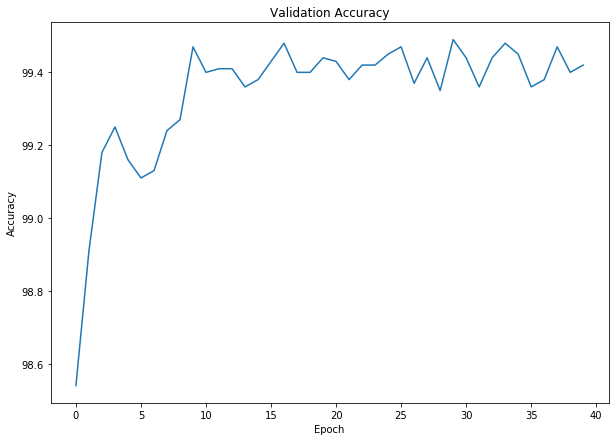

In [0]:
import matplotlib.pyplot as plt

val_acc_fig, axs = plt.subplots(1,1,figsize=(10,7))

# Test accuracy plot
axs.plot(test_acc)
axs.set_title("Validation Accuracy")
axs.set_xlabel("Epoch")
axs.set_ylabel("Accuracy")
val_acc_fig.savefig('/content/gdrive/My Drive/Colab Notebooks/S6/Without L1 and L2/validation_accuracy_change_plot.jpg')

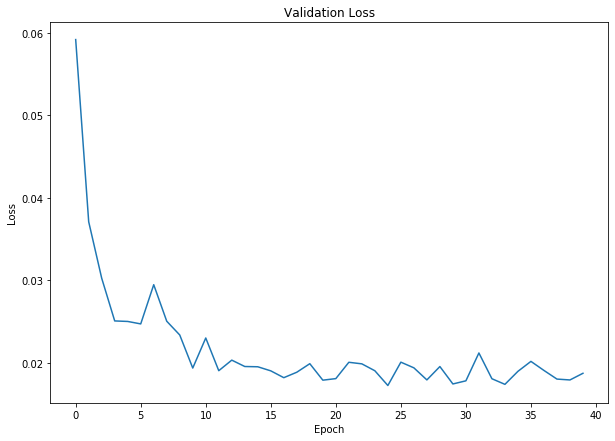

In [0]:
val_loss_fig, axs = plt.subplots(1,1,figsize=(10,7))

# Test loss plot
axs.plot(test_losses)
axs.set_title("Validation Loss")
axs.set_xlabel("Epoch")
axs.set_ylabel("Loss")
val_loss_fig.savefig('/content/gdrive/My Drive/Colab Notebooks/S6/Without L1 and L2/validation_loss_change_plot.jpg')

**Misclassified** **Images**

In [0]:
import numpy as np

from google.colab import files

with torch.no_grad():
        count = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            targetx = target.cpu().numpy()
            predx = pred.cpu().numpy()
            for i, j in enumerate(targetx):
              if count == 25:
                  break
              if targetx[i] != predx[i]:
                fig = plt.figure()
                plt.imshow(np.transpose(data[i].cpu().detach().numpy(), (1, 2, 0)).reshape(28,28))
                fig.suptitle("Actual output: " + str(targetx[i]) + " Predicted output: " + str(predx[i]))
                fig.savefig("/content/gdrive/My Drive/Colab Notebooks/S6/Without L1 and L2/Misclassified Images/image_" + str(count)+".jpg")
                plt.close(fig)
                count += 1